In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
plt.rcParams["figure.figsize"] = (20,18)
plt.style.use('/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/standard.mplstyle')

# Pantheon

In [2]:
data_PS = pd.read_excel('/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/pantheon_final.xlsx') 
z=data_PS.zcmb
amg=data_PS.mb
erramg=data_PS.dmb
label = {"Z_SN":z,"App_Mag":amg,"Error_App_Mag":erramg}
data_SN=pd.DataFrame(label)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
z=sort_data_SN.Z_SN
amg=sort_data_SN.App_Mag
erramg=sort_data_SN.Error_App_Mag
mu=amg + 19.35
errdm=erramg
label = {"Z_SN":z,"App_Mag":amg,"Error_App_Mag":erramg,"DMdata_SN": mu, "Error_DM_SN":errdm}
sort_data_SN=pd.DataFrame(label)
mu=sort_data_SN.DMdata_SN
cov_mat = pd.read_csv(r'/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/sys_full_long.txt') 

In [3]:
cov_mat=pd.DataFrame(cov_mat).to_numpy()
cov_mat=cov_mat.reshape(1048,1048)

In [4]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=np.diag(cov_mat)
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

# inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnlps(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.sum(dmu**2/erramg**2)
        return loglikely

In [5]:
info_PS = {
    "likelihood": {
        "external": lnlps},
    "params": dict([
        ["omega_m", {
            "prior": {"min":0.0, "max":1.0}, "ref": 0.1,
            "latex": r"\Omega_m","proposal":0.001}],
        ["n", {
            "prior": {"min":-4, "max":4}, "ref": 1.2,
            "latex": r"n","proposal":0.001}],
       ["h0", {
            "prior": {"min":0.5, "max":1.0}, "ref": 0.7,
            "latex": r"h","proposal":0.001}] ]),
"sampler": {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1,
             "Rminus1_cl_stop": 0.2, "learn_proposal": True}}}
updated_info_PS, sampler_PS = run(info_PS)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 7.88}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.1, n:1.2, h0:0.7
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-07-09 18:34:04 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.632
[mcmc]  - Convergence of means: R-1 = 4.198157 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-07-09 18:35:04 : 889 steps taken, and 229 accepted.
[mcmc] Learn + convergence test @ 

[root] *WARNING* outlier fraction 0.04836309523809524 
Mean:
[0.11527257 0.32293139 0.70567306]
1 sigma:
[0.02919698 0.2639184  0.00348132]
Covariance matrix:
[[ 8.52463726e-04 -7.31955636e-03  6.47023277e-05]
 [-7.31955636e-03  6.96529201e-02 -7.42854538e-04]
 [ 6.47023277e-05 -7.42854538e-04  1.21195886e-05]]


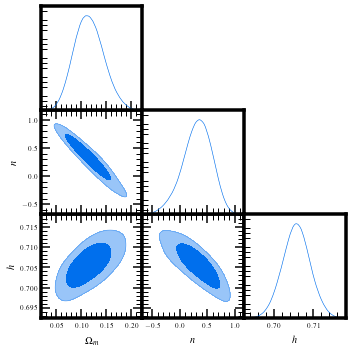

In [6]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_PS, ["omega_m", "n", "h0"], filled=True)

mean = gdsamples_PS.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_PS.getVars()[:3]))
covmat = gdsamples_PS.getCovMat().matrix[:3, :3]
# plt.savefig("figures/Pantheoncobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat)  

# GWTC-3

In [7]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

In [8]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=np.zeros(len(z))
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log((100*D_l(z,omega_m,n,h0))/c,10)+25
        return m

# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnlgw(omega_m, n,h0):
        if(omega_m<=0.0 or omega_m>=1 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)): # if data point lower than theoretical: take bottom error
                # if data point above th : take upper error
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
                if dmu[i]>0:
                    sigma[i]=dmbottomerr[i]
                else:
                    sigma[i]=dmtoperr[i]
            loglikely= -0.5*np.sum(dmu**2/sigma**2)
#             for i in range(len(z)):   #(Average of asymetrical errors)
#                 dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
#                 sigma[i]= (dmbottomerr[i] + dmtoperr[i])/2
#             loglikely= -0.5*np.sum(dmu**2/sigma**2)
        return loglikely

In [9]:
info_GW = {
    "likelihood": {
        "external": lnlgw},
    "params": dict([
        ["omega_m", {
            "prior": {"min":0.0, "max":1.0}, "ref": 0.1,
            "latex": r"\Omega_m","proposal":0.001}],
        ["n", {
            "prior": {"min":-4, "max":4}, "ref": 1.2,
            "latex": r"n","proposal":0.001}],
       ["h0", {
            "prior": {"min":0.5, "max":1.0}, "ref": 0.7,
            "latex": r"h","proposal":0.001}] ]),
"sampler": {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1, "Rminus1_cl_stop": 0.2, "learn_proposal": True}}}

updated_info_GW, sampler_GW = run(info_GW)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 98.4}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.1, n:1.2, h0:0.7
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-07-09 18:43:28 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.990
[mcmc]  - Convergence of means: R-1 = 13.142666 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.932
[mcmc]  - Convergen

[root] *WARNING* outlier fraction 0.02882205513784461 
Mean:
[ 0.42036583 -0.812542    0.68796363]
1 sigma:
[0.25781095 2.03992557 0.0535779 ]
Covariance matrix:
[[ 6.64664864e-02  3.23587077e-03 -7.52338126e-03]
 [ 3.23587077e-03  4.16129635e+00 -4.75374185e-02]
 [-7.52338126e-03 -4.75374185e-02  2.87059138e-03]]


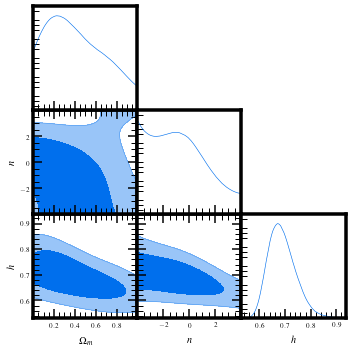

In [10]:
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_GW, ["omega_m", "n", "h0"], filled=True)
mean = gdsamples_GW.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_GW.getVars()[:3]))
covmat = gdsamples_GW.getCovMat().matrix[:3, :3]
# plt.savefig("figures/GWTCcobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat) 

In [5]:
import numpy as np
a = np.array([1,2,3,4])
a[]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed